In [15]:
import warnings
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 7.5)
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
torch.manual_seed(0)

import networkx as nx
import pandas as pd

from sklearn.neighbors import KernelDensity

from ConDist import CsvDataset, ConDist_MO
from reinforcement import environment, Policy, reinforce, evaluate
from metrics import causal_edge_score, causal_cfe_from_parent, sparsity_num, sparsity_cat, L1
warnings.filterwarnings("ignore")

### The SCM

In [3]:
def prob_func_x4(a,b,c):
    prob1 = abs(a/100) + 0.1*(b==0) + 0.1*(b==2) * np.sqrt(abs(c)) 
    prob2 = 0.3*(b==1) + 0.4*(b==3) + c/10
    prob3 = a/100*c/10 + 0.1
    return np.array([prob1, prob2, prob3])/ sum([prob1, prob2, prob3])
SCM = {0:{'input':[], 'func':None}, 1:{'input':[], 'func':None}, 2:{'input':[], 'func':None},\
     3:{'input':[2], 'func':lambda a: (a-3)**2}, 4:{'input':[0,1,3], 'func':prob_func_x4}}

In [4]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'

### Train the classifier

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer

In [6]:
clf_data_train = pd.read_csv('./sim_data/sim_cat_data_train.csv')
clf_data_test = pd.read_csv('./sim_data/sim_cat_data_test.csv')

In [7]:
target = clf_data_train["y"]
# Split data into train and test
x_train= clf_data_train.drop("y", axis=1)

categorical = []
numerical = x_train.columns.difference(categorical)

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='error'))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', MLPClassifier(random_state=0))])
model = clf.fit(x_train, clf_data_train['y'])

In [8]:
# classifier acc
np.mean(clf.predict(clf_data_test.drop('y', axis=1)) == clf_data_test['y'])

0.98875

In [9]:
pred_train = clf.predict(clf_data_train.drop('y', axis=1)).astype('int')
pred_test = clf.predict(clf_data_test.drop('y', axis=1)).astype('int')
cf_data_train = clf_data_train.drop('y', axis=1)[pred_train==0]
cf_data_test = clf_data_test.drop('y', axis=1)[pred_test==0]
scm = SCM

In [10]:
# We should use all train set to estimate conditinoal distribution, not just the data with undesired class.
# The conditional distribution should be estimated at normalized scale
cat_feats = [1, 4]
train_num_mean = clf_data_train.drop(['x1','x4','y'], axis=1).mean()
train_num_std = clf_data_train.drop(['x1','x4','y'], axis=1).std()
train_data_norm = clf_data_train.drop('y', axis=1)
train_data_norm[['x0', 'x2', 'x3']] = ((train_data_norm[['x0', 'x2', 'x3']] - train_num_mean)/ train_num_std).to_numpy()
dist_nets = {}
# for out_feat in scm.keys():
#     in_feats = scm[out_feat]['input']
#     if in_feats:
#         # has input features, is endogenous
#         dataset = CsvDataset(train_data_norm, in_feats, out_feat, cat_feats)
#         dataloader = DataLoader(dataset, batch_size=256, shuffle=True)
#         # The model config will be determined by the input/output of dataset
#         MVNet = ConDist_MO(dataset, device='cuda')
#         MVNet.fit(dataloader, 5000)
#         MVNet.to('cpu')
#         dist_nets[out_feat] = {}
#         dist_nets[out_feat]['input'] = in_feats
#         dist_nets[out_feat]['net'] = MVNet

In [11]:
# with open('./cd_models/sim_mo.pickle', 'wb') as f:
#     pickle.dump(dist_nets, f)
with open('./cd_models/sim_mo.pickle', 'rb') as f:
    dist_nets = pickle.load(f)

In [18]:
DONE_THRESHOLD = 0.5
REG_BETA = 1.2
CON_DIST_BETA = 8
ACTION_ENTROPY_BETA = 0.01
N_ALLOWED_STD = 2
MAX_STEP = 5
CAT_CAHNGE_PENALTY = 0.1
cat_feats = [1, 4]
cat_feats_names = train_data_norm.columns[cat_feats]
n_classes = [len(np.unique(train_data_norm[name])) for name in cat_feats_names]
disallowed_feats = []
directions = {}
policy = Policy(n_feats=5, cat_feats=cat_feats, n_classes=n_classes, disallowed_feats=disallowed_feats, hidden_size=128).to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-4)
env = environment(clf, clf_data_train.drop('y',axis=1).mean().to_numpy(), clf_data_train.drop('y',axis=1).std().to_numpy(),\
     train_data_norm.min().to_numpy(), train_data_norm.max().to_numpy(), cat_feats, list(cf_data_train.columns), \
     scm, DONE_THRESHOLD, REG_BETA, cat_change_penalty=CAT_CAHNGE_PENALTY, max_step=MAX_STEP, disallowd_feats=disallowed_feats, directions=directions, order_matter=False)
scores = reinforce(cf_data_train, env, policy, optimizer, checkpoint_path='./ckpt_sim', n_episodes=100000, print_every=1000, con_dist=dist_nets, n_allowed_std=N_ALLOWED_STD, CON_DIST_BETA=CON_DIST_BETA, ACTION_ENTROPY_BETA = ACTION_ENTROPY_BETA, device=device)
# r = evaluate(cf_data_test, env, policy, device=device, print_file='./result.txt')

Episode 1000	Average Score: 3.21
Episode 2000	Average Score: 3.16
Episode 3000	Average Score: 3.11
Episode 4000	Average Score: 3.31
Episode 5000	Average Score: 3.14
Episode 6000	Average Score: 3.11
Episode 7000	Average Score: 3.22
Episode 8000	Average Score: 3.23
Episode 9000	Average Score: 3.18
Episode 10000	Average Score: 3.29
Episode 11000	Average Score: 3.23
Episode 12000	Average Score: 3.24
Episode 13000	Average Score: 3.19
Episode 14000	Average Score: 3.29
Episode 15000	Average Score: 3.42
Episode 16000	Average Score: 3.37
Episode 17000	Average Score: 3.53
Episode 18000	Average Score: 3.53
Episode 19000	Average Score: 3.79
Episode 20000	Average Score: 3.67
Episode 21000	Average Score: 3.75
Episode 22000	Average Score: 3.92
Episode 23000	Average Score: 3.96
Episode 24000	Average Score: 3.99
Episode 25000	Average Score: 4.05
Episode 26000	Average Score: 4.19
Episode 27000	Average Score: 4.39
Episode 28000	Average Score: 4.37
Episode 29000	Average Score: 4.42
Episode 30000	Average S

In [17]:
# the best model may overfit
with open('./ckpt_sim/model_70000.pt', 'rb') as f:
    policy = torch.load(f)

In [18]:
r = evaluate(cf_data_test, env, policy, device=device, print_file='./result_sim.txt')
cfs = pd.DataFrame(r['CF'], columns=cf_data_test.columns)

In [53]:
with open('./sim_ces.pickle', 'rb') as f:
    cess = pickle.load(f)
cess_cf = np.array([ces.evaluate(cf_data_test.to_numpy(), np.array(r['CF'])) for ces in cess])

In [30]:
cat_feats = ['x1', 'x4']
print('validity:', np.mean(model.predict(cfs)))
print('causal_edge_score(median): ', np.mean(np.median(cess_cf, axis=1)))
print('causal_edge_score(average): ', np.mean(cess_cf))
print('sparsity_num: ', sparsity_num(cfs, cf_data_test, cat_feats=cat_feats))
print('sparsity_cat: ', sparsity_cat(cfs, cf_data_test, cat_feats=cat_feats))
print('L1: ', L1(cfs, cf_data_test, cat_feats=cat_feats, stds=clf_data_train.std()))

validity: 0.9975308641975309
causal_edge_score(median):  0.012236996729811933
causal_edge_score(average):  -0.18585003642033146
sparsity_num:  0.6518518518518519
sparsity_cat:  0.6395061728395062
L1:  0.47336661669409164


In [31]:
print('sparsity_num(causal perspective): ', np.mean(np.array(r['reg'])[:,[0,2,3]]==0))
print('sparsity_cat(causal perspective): ', np.mean(np.array(r['reg'])[:,[1,4]]==0))
print('L1(causal perspective): ', np.mean(np.abs(np.array(r['reg'])[:,[0,2,3]])))

sparsity_num(causal perspective):  0.6518518518518519
sparsity_cat(causal perspective):  0.9012345679012346
L1(causal perspective):  [0.46089415]


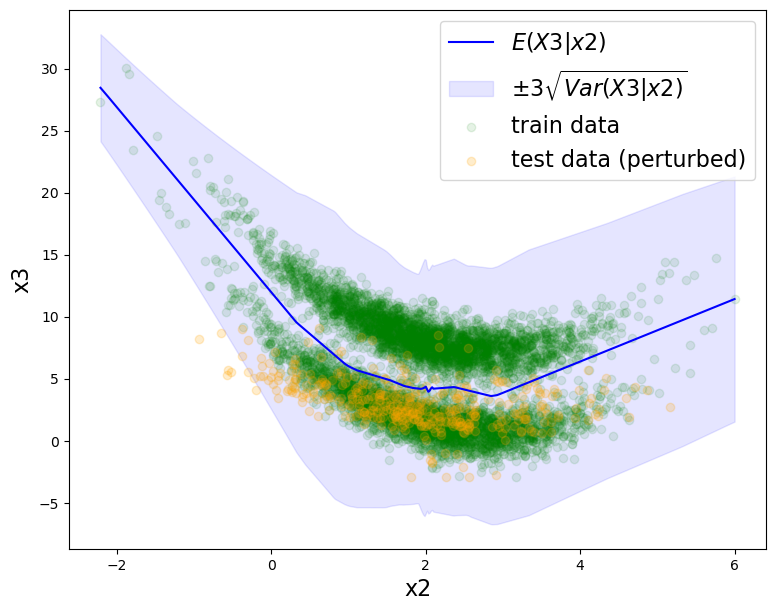

In [29]:
plt.rcParams['figure.figsize'] = (9, 7)
n_samples = 500
x2 = np.linspace(clf_data_train['x2'].min(), clf_data_train['x2'].max(), n_samples)
x2_norm = torch.tensor((x2 - clf_data_train['x2'].mean() / clf_data_train['x2'].std()).astype('float32')).unsqueeze(1)
mean, var = dist_nets[3]['net'](x2_norm)
mean, var = mean.squeeze().detach().numpy(), var.squeeze().detach().numpy()
mean = mean * clf_data_train['x3'].std() + clf_data_train['x3'].mean()
std = np.sqrt(var) * clf_data_train['x3'].std()

plt.xlabel('x2',fontsize=16)
plt.ylabel('x3',fontsize=16)
plt.plot(x2, mean, label=r'$E(X3|x2)$', color='blue')
plt.fill_between(x=x2, y1=mean-3*std, y2=mean+3*std, alpha=0.1, label='$\pm 3\sqrt{Var(X3|x2)}$', color='blue')
plt.scatter(clf_data_train['x2'], clf_data_train['x3'], alpha=0.1, label='train data', color='green')
plt.scatter(cfs['x2'], cfs['x3'], alpha=0.2, label='test data (perturbed)', color='orange')
plt.legend(fontsize=16)
plt.show()